# Store Sales - Time Series Forecasting

## Introduction

This project is related to the Kaggle competition 'Store Sales - Time Series Forecasting' url: https://www.kaggle.com/competitions/store-sales-time-series-forecasting . The goal is to use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer. For grocery stores, more accurate forecasting can decrease food waste related to overstocking and improve customer satisfaction.

Specifically, I aim to build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita store by applying machine learning skills to a training dataset of dates, store, and item information, promotions, and unit sales (the target).

## The Data

File Descriptions and Data Field Information

train.csv

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
store_nbr identifies the store at which the products are sold.
family identifies the type of product sold.
sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

test.csv

The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
The dates in the test data are for the 15 days after the last date in the training data.

stores.csv

Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.

oil.csv

Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

holidays_events.csv

Holidays and Events, with metadata
NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

#### Additional Notes

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from forecasting_utils import *

### Import the Data

In [2]:
holidays_events_dir = 'data/holidays_events.csv'
oil_dir = 'data/oil.csv'
stores_dir = 'data/stores.csv'
test_dir = 'data/test.csv'
train_dir = 'data/train.csv'
transactions_dir = 'data/transactions.csv'

holidays_events = pd.read_csv(holidays_events_dir, parse_dates=['date'], infer_datetime_format=True)
stores = pd.read_csv(stores_dir)
train = pd.read_csv(train_dir, parse_dates=['date'], infer_datetime_format=True)
transactions = pd.read_csv(transactions_dir, parse_dates=['date'], infer_datetime_format=True)
oil = pd.read_csv(oil_dir, parse_dates=['date'], infer_datetime_format=True)
test = pd.read_csv(test_dir, parse_dates=['date'], infer_datetime_format=True)

store_sales = train.copy()
store_sales['date'] = train.date.dt.to_period('D')
store_sales = store_sales.set_index(['date', 'store_nbr', 'family']).sort_index()

test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date', 'store_nbr', 'family']).sort_index()

train.onpromotion.astype("float16")
train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")
test.onpromotion.astype("float16")


date        store_nbr  family                    
2017-08-16  1          AUTOMOTIVE                     0.0
                       BABY CARE                      0.0
                       BEAUTY                         2.0
                       BEVERAGES                     20.0
                       BOOKS                          0.0
                                                     ... 
2017-08-31  54         POULTRY                        0.0
                       PREPARED FOODS                 0.0
                       PRODUCE                        1.0
                       SCHOOL AND OFFICE SUPPLIES     0.0
                       SEAFOOD                        0.0
Name: onpromotion, Length: 28512, dtype: float16

In [3]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


### Trends

The data has several inputs. I first simplify the problem by forecasting the mean daily sales through all stores and products. I start by looking for a trend.

In [4]:
mean_daily_sales = train.groupby('date').mean()['sales']
mean_weekly_sales = mean_daily_sales.rolling(window=7, center=True, min_periods=3).mean()
mean_monthly_sales = mean_daily_sales.rolling(window=30, center=True, min_periods=15).mean()
mean_yearly_sales = mean_daily_sales.rolling(window=365, center=True, min_periods=183).mean()

C:\Users\HM191112\AppData\Local\Temp\ipykernel_4312\3468515048.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_daily_sales = train.groupby('date').mean()['sales']


<Axes: xlabel='date'>

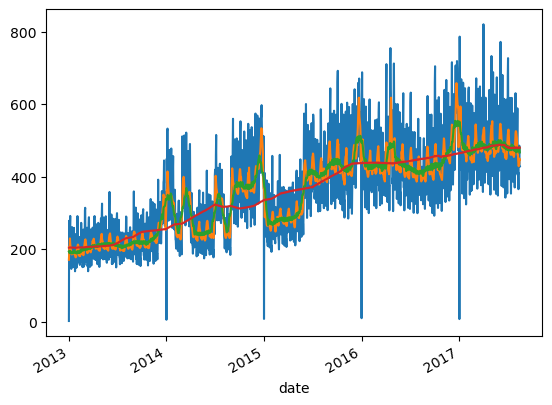

In [5]:
mean_daily_sales.plot()
mean_weekly_sales.plot()
mean_monthly_sales.plot()
mean_yearly_sales.plot()


There seems to be a linear upward trend. A trend line of order 1 seems appropriate.

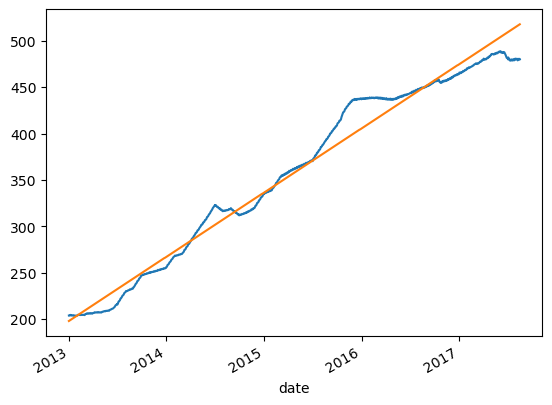

In [75]:
dp = DeterministicProcess(index=mean_yearly_sales.index, constant=True, order=1, drop=True)
X = dp.in_sample()
y = mean_yearly_sales
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

trend = pd.Series(model.predict(X), index=X.index)

ax = mean_yearly_sales.plot()
_ = trend.plot(ax=ax)

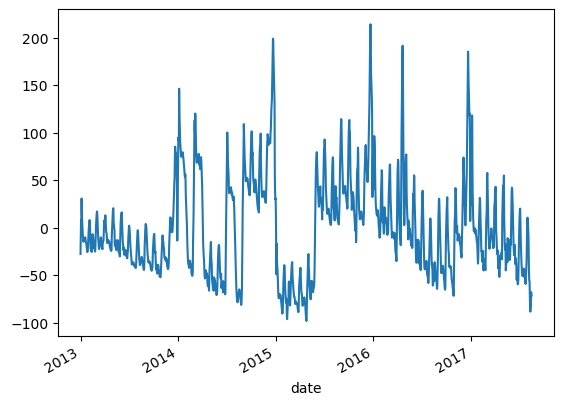

In [107]:
ax=(mean_weekly_sales-trend).plot()

## Seasonality

After removing the trend, there is clear seasonality to the data. I will now explore this.

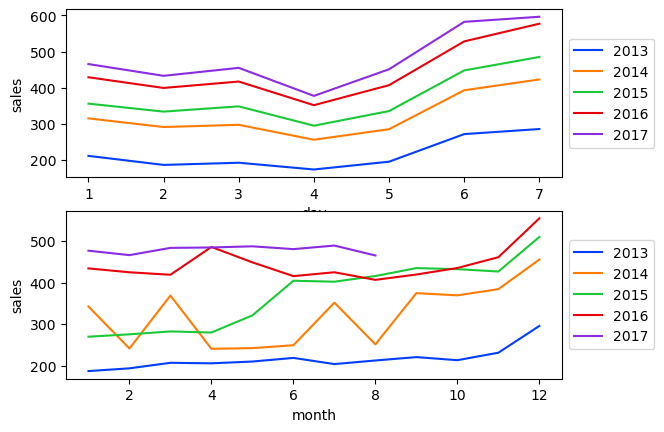

In [78]:
seasonal_graph_data = train.copy()
seasonal_graph_data["year"] = seasonal_graph_data.date.dt.year
seasonal_graph_data["day"] = seasonal_graph_data.date.dt.dayofweek + 1
seasonal_graph_data["month"] = seasonal_graph_data.date.dt.month
daily_graph_data = seasonal_graph_data.groupby(["year", "day"]).sales.mean().reset_index()
monthly_graph_data = seasonal_graph_data.groupby(["year", "month"]).sales.mean().reset_index()

fig, axes = plt.subplots(2, 1)
sns.lineplot(daily_graph_data, x="day", y='sales', hue='year', palette="bright", ax=axes[0])
sns.lineplot(monthly_graph_data, x="month", y='sales', hue='year', palette="bright", ax=axes[1])
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


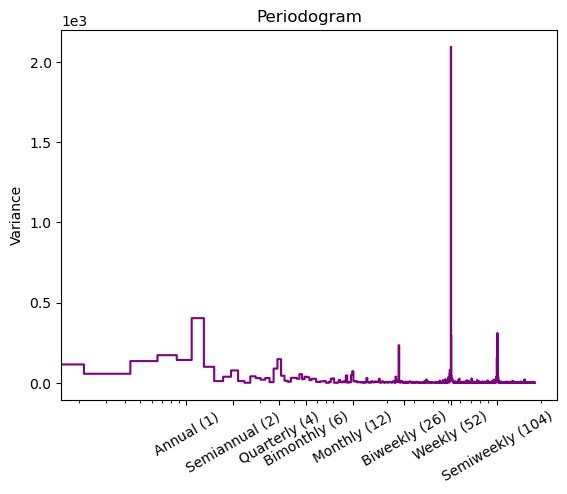

In [79]:
from forecasting_utils import plot_periodogram
plot_periodogram(mean_daily_sales-trend);

There appears to be weekly, monthly and annual seasonality to the data. More specifically, there are more sales at weekends, more sales in December.

In [80]:
monthly_fourier = CalendarFourier(freq="M", order=4)
yearly_fourier = CalendarFourier(freq="A", order=4)

In [81]:
y=(mean_daily_sales-trend).copy()
y.index=train.groupby('date').mean().reset_index()['date'].dt.to_period('D')

dp = DeterministicProcess(index=y.index,
                          constant=False,
                          order=0,
                          seasonal=True,
                          additional_terms=[monthly_fourier, yearly_fourier],
                          drop=True
                          )
X=dp.in_sample()
print(X.columns)

Index(['s(1,7)', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)',
       'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)',
       'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)', 'cos(4,freq=M)',
       'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)',
       'cos(2,freq=A-DEC)', 'sin(3,freq=A-DEC)', 'cos(3,freq=A-DEC)',
       'sin(4,freq=A-DEC)', 'cos(4,freq=A-DEC)'],
      dtype='object')


C:\Users\HM191112\AppData\Local\Temp\ipykernel_4312\383020930.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y.index=train.groupby('date').mean().reset_index()['date'].dt.to_period('D')


In [95]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
seasonal_fit = pd.Series(model.predict(X), index=trend.index)

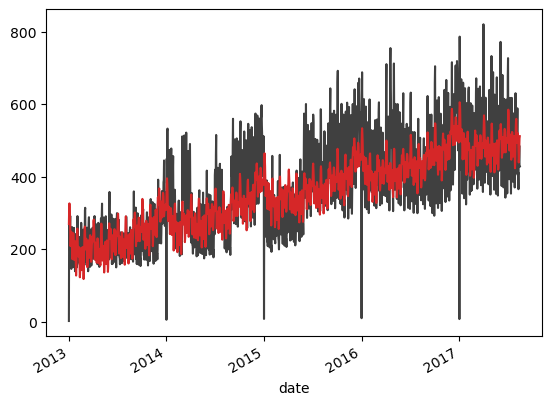

In [115]:
predictions = (trend + seasonal_fit)
ax = mean_daily_sales.plot(color='0.25')
ax = predictions.plot(ax=ax, color='C3')

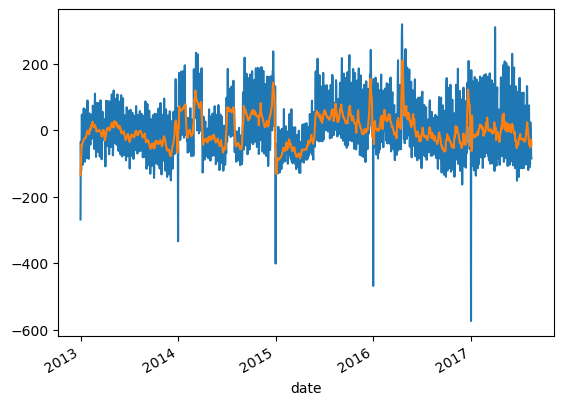

In [104]:
deseasoned_sales = (mean_daily_sales - predictions).copy();
ax = deseasoned_sales.plot()
_ = deseasoned_sales.rolling(window=7, center=True, min_periods=3).mean().plot(ax=ax)

The new predictions fit nicely, but still has some limitations. For example it doesn't account for stores being closed at new-year.

## Holidays

Whilst some holidays have a clear impact, the forcast horizon only contains one holiday (Fundacion de Ambato). There is no similar training data for this holiday. Therefore, for now, I will focus on other information that could aid the forecast.

In [177]:
test_holidays = holidays_events[(holidays_events['date'] <= '2017-08-30') & (holidays_events['date'] > '2017-08-15')]
train_holidays = holidays_events[(holidays_events['date'] <= '2017-08-15') & (holidays_events['locale'].isin(['Regional', 'National']))]

display(test_holidays)

train_holidays['description'].unique()

,date,type,locale,locale_name,description,transferred
327,2017-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False


array(['Provincializacion de Cotopaxi', 'Provincializacion de Imbabura',
       'Primer Grito de Independencia', 'Independencia de Guayaquil',
       'Traslado Independencia de Guayaquil', 'Dia de Difuntos',
       'Independencia de Cuenca', 'Provincializacion de Santo Domingo',
       'Provincializacion Santa Elena', 'Navidad-4', 'Navidad-3',
       'Navidad-2', 'Puente Navidad', 'Navidad-1', 'Navidad', 'Navidad+1',
       'Puente Primer dia del ano', 'Primer dia del ano-1',
       'Primer dia del ano', 'Recupero puente Navidad',
       'Recupero puente primer dia del ano', 'Carnaval', 'Viernes Santo',
       'Dia del Trabajo', 'Dia de la Madre-1', 'Dia de la Madre',
       'Batalla de Pichincha', 'Inauguracion Mundial de futbol Brasil',
       'Mundial de futbol Brasil: Ecuador-Suiza',
       'Mundial de futbol Brasil: Ecuador-Honduras',
       'Mundial de futbol Brasil: Ecuador-Francia',
       'Mundial de futbol Brasil: Octavos de Final',
       'Mundial de futbol Brasil: Cuartos d

In [182]:
display(train_holidays[train_holidays['locale_name'] == 'Ambato'])

,date,type,locale,locale_name,description,transferred


In [187]:
display(train_holidays[train_holidays['locale'] == 'Local'])

,date,type,locale,locale_name,description,transferred
